In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
n_features = 10
n_samples = 1000
n_layers = 2
layer_size = 32
activation = nn.ReLU()
loss_fn = nn.MSELoss()
learning_rate = 0.01
epochs = 50

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используем устройство: {device}')

Используем устройство: cpu


In [ ]:
datasets = []
for i in range(3):
    X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=0.1, random_state=i)
    # y = np.sin(X[:, 0] * 2 + X[:, 1] * 3 + X[:, 2] * 5) + 0.1 * np.random.randn(n_samples)
    y = np.tanh(X[:, 0] * 2 + X[:, 1] * 3 + X[:, 2] * 5) + 0.1 * np.random.randn(n_samples)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    datasets.append((X, y))

**Часть 1: тестирование с 3 разными размера батча**

Датасет 1
Лучший размер батча для Dataset 1: 16
Датасет 2
Лучший размер батча для Dataset 2: 32
Датасет 3
Лучший размер батча для Dataset 3: 8


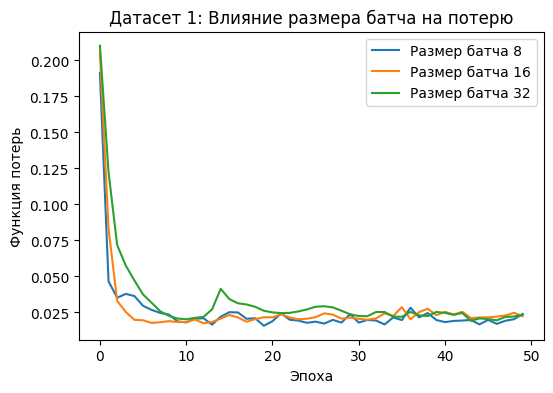

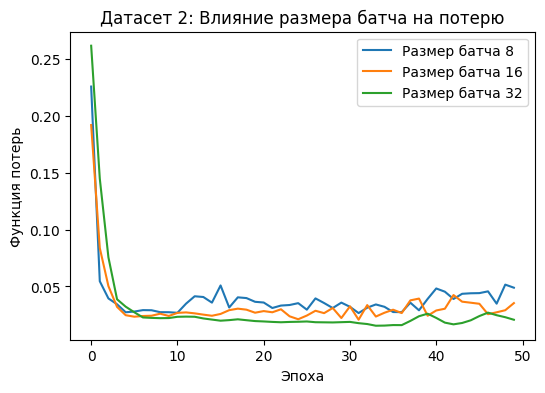

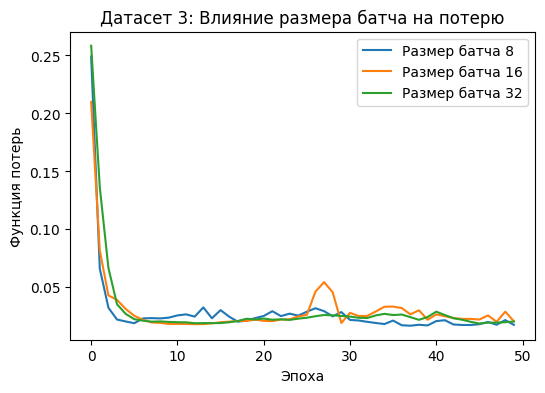

In [ ]:
batch_sizes = [8, 16, 32]
results_batchnorm = []
best_batch_sizes = []

for i, (X, y) in enumerate(datasets):
    print(f"Датасет {i+1}")
    results_batchnorm_dataset = []
    best_batch_size = None
    best_loss = float('inf')

    train_size = int(0.8 * len(X))
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    for batch_size in batch_sizes:
        model = nn.Sequential(
            nn.Linear(n_features, layer_size),
            nn.ReLU(),
            nn.BatchNorm1d(layer_size),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.BatchNorm1d(layer_size),
            nn.Linear(layer_size, 1)
        ).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        train_losses = []
        test_losses = []
        for epoch in range(epochs):
            for j in range(0, len(X_train), batch_size):
                inputs = X_train[j:j+batch_size]
                targets = y_train[j:j+batch_size]
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()
            train_losses.append(loss.item())

            model.eval()

            with torch.no_grad():
                outputs = model(X_test)
                loss = loss_fn(outputs, y_test)
                test_losses.append(loss.item())


        # Визуализация кривой обучения
        # plt.figure(figsize=(6, 4))
        # plt.plot(range(epochs), train_losses, label='Обучение')
        # plt.plot(range(epochs), test_losses, label='Тестирование')
        # plt.xlabel('Эпоха')
        # plt.ylabel('Функция потерь')
        # plt.title(f'Датасет {i+1}, Batch Size {batch_size}: Кривые обучения')
        # plt.legend()
        # plt.show()

        results_batchnorm_dataset.append((batch_size, test_losses))

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_batch_size = batch_size


    results_batchnorm.append(results_batchnorm_dataset)
    best_batch_sizes.append(best_batch_size)
    print(f"Лучший размер батча для Dataset {i+1}: {best_batch_size}")


for i, results in enumerate(results_batchnorm):
    plt.figure(figsize=(6, 4))
    for batch_size, test_losses in results:
        # plt.plot(range(epochs), train_losses, label=f'Batch Size {batch_size} (Обучение)')
        plt.plot(range(epochs), test_losses, label=f'Размер батча {batch_size}')
    plt.xlabel('Эпоха')
    plt.ylabel('Функция потерь')
    plt.title(f'Датасет {i+1}: Влияние размера батча на потерю')
    plt.legend()
    plt.show()

**Часть 2: тестирование с разными комбинациями батчнорма и дропаута**

Датасет 1


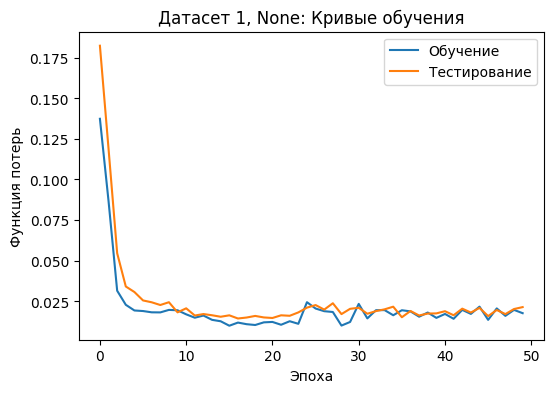

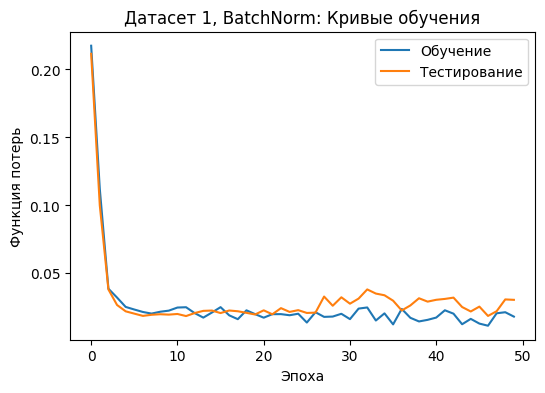

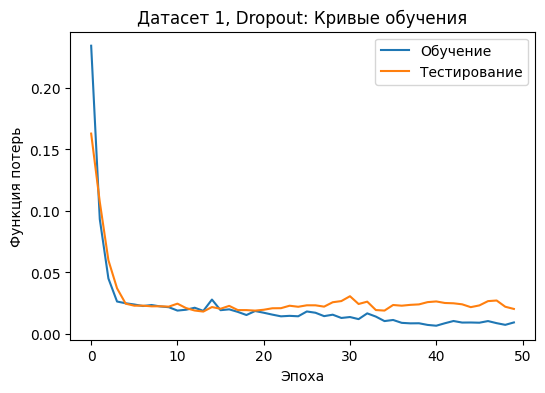

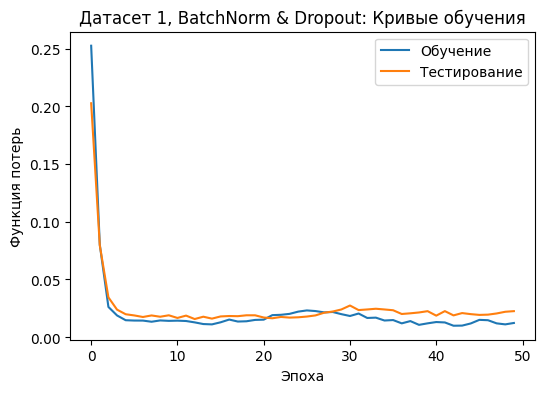

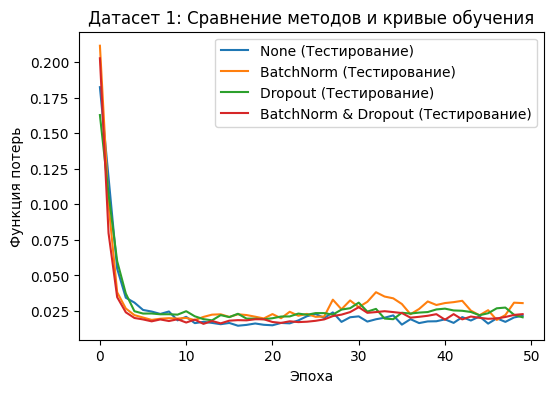

Датасет 2


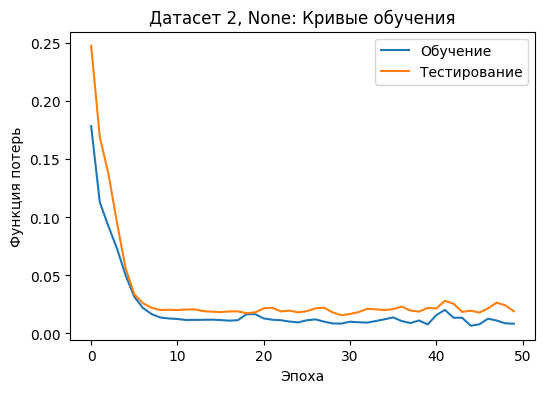

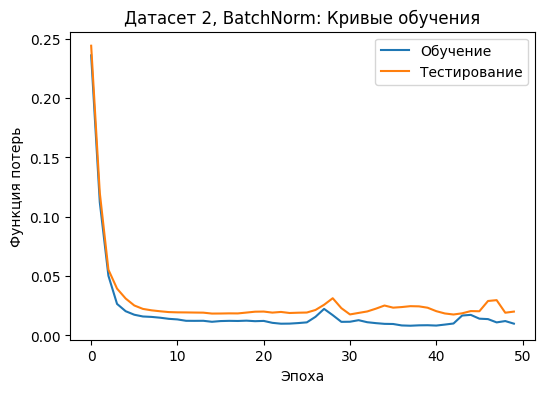

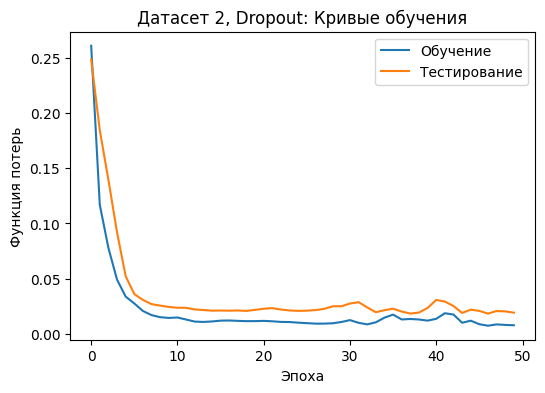

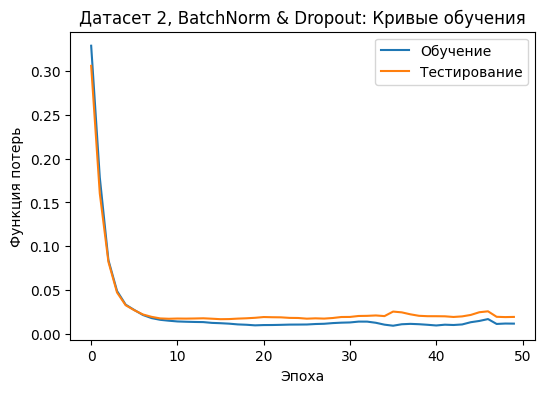

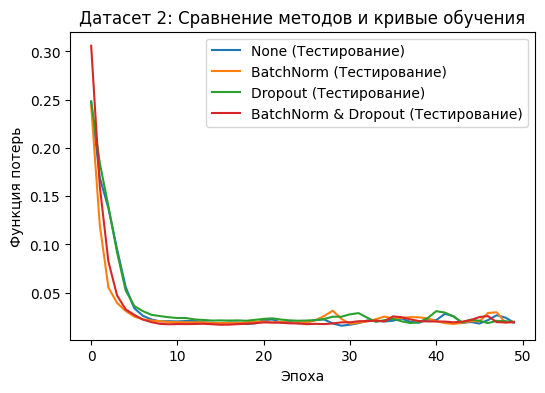

Датасет 3


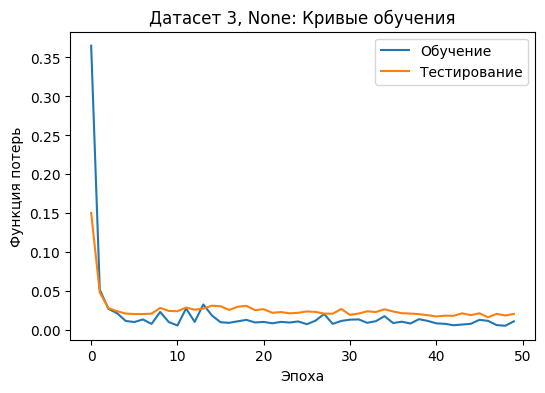

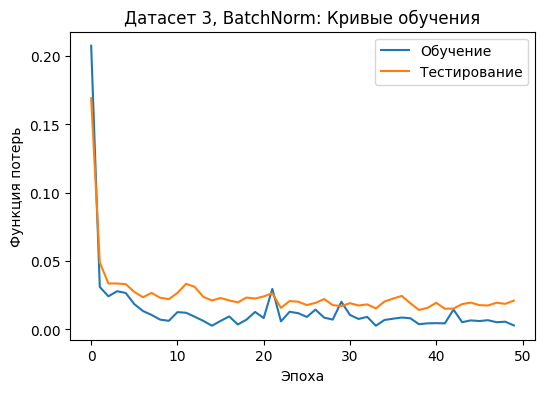

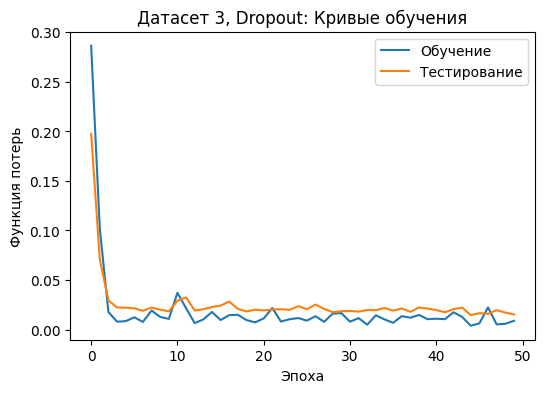

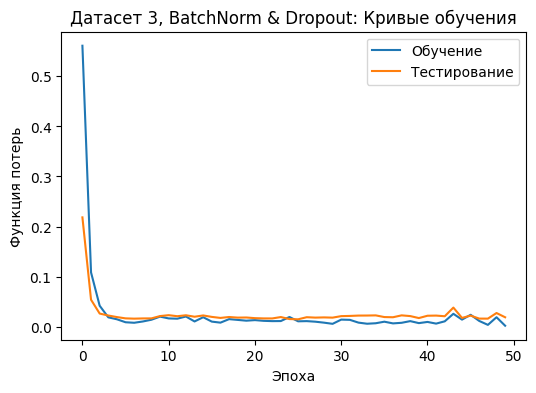

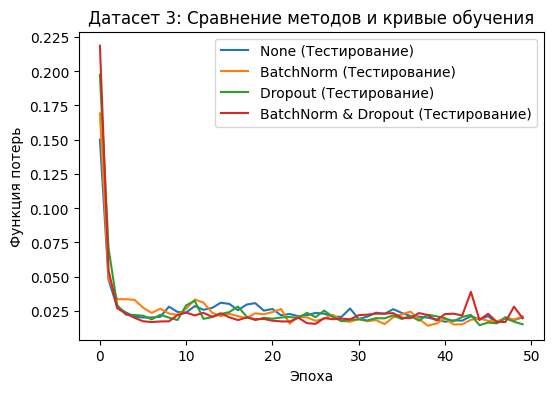

In [ ]:
results_variations = []

for i, (X, y) in enumerate(datasets):
    print(f"Датасет {i+1}")
    results_variations_dataset = []

    train_size = int(0.8 * len(X))
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]


    for variation in ['None', 'BatchNorm', 'Dropout', 'BatchNorm & Dropout']:
        if variation == 'None':
            model = nn.Sequential(
                nn.Linear(n_features, layer_size),
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.ReLU(),
                nn.Linear(layer_size, 1)
            ).to(device)
        elif variation == 'BatchNorm':
            model = nn.Sequential(
                nn.Linear(n_features, layer_size),
                nn.ReLU(),
                nn.BatchNorm1d(layer_size),
                nn.Linear(layer_size, layer_size),
                nn.ReLU(),
                nn.BatchNorm1d(layer_size),
                nn.Linear(layer_size, 1)
            ).to(device)
        elif variation == 'Dropout':
            model = nn.Sequential(
                nn.Linear(n_features, layer_size),
                nn.Dropout(0.2),
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.Dropout(0.2),
                nn.ReLU(),
                nn.Linear(layer_size, 1)
            ).to(device)
        else:
            model = nn.Sequential(
                nn.Linear(n_features, layer_size),
                nn.Dropout(0.2),
                nn.ReLU(),
                nn.BatchNorm1d(layer_size),
                nn.Linear(layer_size, layer_size),
                nn.Dropout(0.2),
                nn.ReLU(),
                nn.BatchNorm1d(layer_size),
                nn.Linear(layer_size, 1)
            ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)


        train_losses = []
        test_losses = []

        for epoch in range(epochs):
            for j in range(0, len(X_train), best_batch_sizes[i]):
                inputs = X_train[j:j+best_batch_sizes[i]]
                targets = y_train[j:j+best_batch_sizes[i]]
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()
            train_losses.append(loss.item())


            model.eval()
            with torch.no_grad():
                outputs = model(X_test)
                loss = loss_fn(outputs, y_test)
                test_losses.append(loss.item())


        plt.figure(figsize=(6, 4))
        plt.plot(range(epochs), train_losses, label='Обучение')
        plt.plot(range(epochs), test_losses, label='Тестирование')
        plt.xlabel('Эпоха')
        plt.ylabel('Функция потерь')
        plt.title(f'Датасет {i+1}, {variation}: Кривые обучения')
        plt.legend()
        plt.show()


        results_variations_dataset.append((variation, test_losses))


    plt.figure(figsize=(6, 4))
    for variation, test_losses in results_variations_dataset:
        # plt.plot(range(epochs), train_losses, label=f'{variation} (Обучение)')
        plt.plot(range(epochs), test_losses, label=f'{variation} (Тестирование)')
    plt.xlabel('Эпоха')
    plt.ylabel('Функция потерь')
    plt.title(f'Датасет {i+1}: Сравнение методов и кривые обучения')
    plt.legend()
    plt.show()

    results_variations.append(results_variations_dataset)

В данном случае для этих данных, батч-нормализация оказалась более эффективной, чем дропаут. Комбинация батч-нормализации и дропаута не показала значительного улучшения и даже могла ухудшить производительность.